# Tune residence time based on scavenging removal rates and fraction lithogenic

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
from matplotlib.colors import ListedColormap
import forcing.modules.mapping_functions as mf

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
jsize = jmax-jmin
isize = imax-imin

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_NCB = (1598,2177,777,797) # Northern Canada Basin
bdy_WCB = (2167,2177,390,797) # Western Canada Basin
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,291,301) # Hudson Bay
land_color  = '#a9a7a2'
g = '#c1c1c1'

#### Load files:

In [3]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mfile    = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = mfile['nav_lon'].values
mesh_lat = mfile['nav_lat'].values
mask     = mfile['tmask'].values[0]
mesh_bathy   = mfile['tmask'].values[0,:,:,:]
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = mfile['nav_lev'].values
mesh_dz      = np.diff(mesh_depth, prepend=0)

In [4]:
# Modified ANHA12 mesh mask file (http://knossos.eas.ualberta.ca/anha/anhatable.php)
mesh  = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
hdept = mesh['hdept'].values[0,:,:]

In [7]:
np.array([17,37,5,54,11,36,85,103])/365 # days

array([0.04657534, 0.10136986, 0.01369863, 0.14794521, 0.03013699,
       0.09863014, 0.23287671, 0.28219178])

In [42]:
# Observed Pb residence times:
# Pb residence time estimates from the literature: (Observations summary table: https://www.overleaf.com/read/pwyprcnqqscp)

# Kadko et al., 2018: collected August 20 - October 5, 2015
kadko_lats      = np.array([76.511, 79.997, 83.755, 87.520, 88.407, 89.987, 87.815, 85.135, 82.491, 80.369, 78.180, 77.503, 76.998, \
                  76.505, 73.506, 73.008])
kadko_lons      = np.array([-173.034, -174.962, 174.915, -179.809, -176.761, -89.25, -149.734, -150.063, -149.872, -149.855, -147.831, -148.009, -148.803, \
                  -149.515, -156.808, -158.729])
kadko_depths    = np.array([56, 52, 52, 46, 20, 23, 45, 41, 47, 49, 40, 47, 40, 40, 46, 36])
kadko_res       = np.array([0.69, 0.76, 0.94, 0.24, 0.76, 0.27, 0.33, 0.71, 1.07, 0.65, 0.31, 0.36, 0.41, 0.28, 0.38, 0.18])
# Residence times are average based on the surface to the given depth, so calculate the average depth:
kadko_ave_depth = (kadko_depths - 0) / 2

# Chen et al., 2012: Chukchi Sea / Bering Strait
chen_lats   = np.array([69.996, 73.998, 68.919, 70.495, 71.579, 71.261, 73.995, 73.380])
chen_lons   = np.array([-168.999, -168.991, -167.009, -162.976, -164.013, -150.376, -156.332, -151.883])
chen_depth  = np.array([30,40,10,30,40,20,30,100])
chen_res    = np.array([17,37,5,54,11,36,85,103])/365 # given initially in units of days
# Average depth based on average of sampled depths listed in table 1
chen_ave_depth = np.array([13, 23.3, 5, 15, 22, 10, 15, 50])

# Find indeces of Kadko and Chen stations within ANHA12 domain
kadko_ANHA12_i, kadko_ANHA12_j = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon, mesh_lat) 
chen_ANHA12_i,  chen_ANHA12_j  = mf.find_indeces_vector(chen_lons, chen_lats, mesh_lon, mesh_lat) 

# Henderson and Maier-Reimer, 2002: North Atlantic 
HMR_depth       = [75, 2000]
HMR_restime     = [3, 30] 
HMR_restime_err = [[2,20],[7,70]]   # error bars for ranges in residence time in model
HMR_ave_depth   = [75/2., 2000/2.]  # average over upper 75 m and upper 2000 m

# Bacon et al., 1976: Atlantic Ocean
Bacon_depth     = [50, 100, 4880, 5003, 3820, 4940, 4950, 4440, 4720, 4580] 
Bacon_ave_depth = [50/2, 100/2, (4880+990)/2, (5003+700)/2, (3820+666)/2, (4940+451)/2, (4950+887)/2, (4440+960)/2, (4720+984)/2, (4580+977)/2]
Bacon_restime   = [1.4, 2.3, 20, 21, 54, 93, 90, 60, 41, 52] 

# Moore and Smith, 1986: 
MS_depth     = [50, 1200] # below 255-1200 m
MS_ave_depth = [(50+0)/2, (1200+255)/2]
MS_restime   = [5, 21] 

# Schaule and Patterson, 1983; Sargasso Sea
# At depths below 1500 m, excluding the bottom waters. A conventional box model indicates a longer residence time in the deep waters 
# of the Sargasso Sea (170 years) than in these marginal parts of the North Atlantic (24 years and 20 to 90 years respectively) and 
# longer than at the central northeast Pacific station 17, where the common lead distribution was studied (115 yearsl) but within the 
# range of values determined at other stations within the Pacific, ranging up to 4uO years in the central North Pacific
# Assuming that similar correction factors apply in the northern Sargasso Sea, the residence time of lead in northwestern Atlantic
# deep waters probably lies between 100 and 150 years
# schaul_depth     = []
# schaul_ave_depth = []
# schaul_restime    = [1.6, 50]
# schaul_restime    = [0, 50-300]

### Ones with only surface, intermediate or deep defined:
sid_depth = [5, 1500, 3000]
craig_restime   = [2, np.nan, 54]   # Craig et al., 1973; Pacific Ocean 1700-4300 m

# Schaule and Patterson, 1981: North Pacific
schaul1_depth     = []
schaul1_ave_depth = []
schaul1_restime   = [np.nan, 20, 80]  # at least 20 years in the 100 to 900 m

# Craig et al., 1973: Pacific Ocean
craig_depth     = [4100]
craig_ave_depth = [(4100+1791)/2]
craig_restime   = [20, 54]

### Nozaki et al., 1976: Pacific Ocean
nozaki_restime  = [1.7, 50, 100]    
nozaki_depth    = [5, 4000, 4000]   
nozaki_std_depth = [5, 1000, 1000]

#### Functions

In [26]:
def load_monthly_comp(folder, year, month):
    # Load file of monthly average:    
    comp = xr.open_dataset(f'{folder}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc')

    dpb      = comp['dissolpb'].values[0,:,:,:] # dissolved Pb concentration
    dpb_ads  = comp['dpbads'].values[0,:,:,:]   # scavenging removal
    
    return dpb, dpb_ads

In [27]:
def calc_residence_time(folder, year, month):
    
    dPb, dPb_ads = load_monthly_comp(folder, year, month)
    
    # Inventory of [dPb]:
    inventory = dPb 
    
    # Removal rate of [dPb]:
    removal   = dPb_ads
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time, dPb, dPb_ads

In [28]:
def calc_annual_residence_time(folder, year):
    
    dPb_total  = np.zeros((50,isize,jsize))
    scav_total = np.zeros((50,isize,jsize))
    for month in range(1,13):
        dPb, dPb_ads = load_monthly_comp(folder, year, month)
        dPb_total    = dPb_total  + dPb
        scav_total   = scav_total + dPb_ads 
    
    # Inventory of [dPb]:
    inventory = np.copy(dPb_total)
    
    # Removal rate of [dPb]:
    removal   = np.copy(scav_total)
    
    # Calculate residence time:
    res_time  = inventory / removal
    
    # Convert residence time from seconds to years:
    residence_time = res_time / (3600*24*365)
    
    return residence_time

In [29]:
def plot_layer(variable, layer, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    CB = proj1.pcolormesh(x, y, variable[:,:], cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)  
    proj1.pcolormesh(x, y, bathy_masked[layer,imin:imax,jmin:jmax], cmap=ListedColormap([land_color]), vmin=0, vmax=1)
    
    # Show Arctic Ocean observed residence times only if depth slice shown goes shallower than 60 m.
    if layer < 19:
        x_kadko, y_kadko = proj1(kadko_lons, kadko_lats)
        x_chen,  y_chen  = proj1(chen_lons, chen_lats)
        CB = proj1.scatter(x_kadko, y_kadko, c=kadko_res, s=20, edgecolor='w', linewidth=0.5, \
                          zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
        proj1.scatter(x_chen, y_chen, c=chen_res, s=20, edgecolor='w', linewidth=0.5, \
                     zorder=5, vmin=vmin, vmax=vmax, cmap=cmocean.cm.thermal)
    
    ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Residence time [years]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

#### Calculations

Pb residence time:
$$\tau_{scav} = \frac{inventory\ of\ [dPb]}{removal\ rate\ of\ [dPb]}$$

In [66]:
residence_time_scav1 = calc_annual_residence_time('/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-kscav5/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


#### Spatial variation in residence time

Calculate as scatter plot, with correlation, and show surface plot.

In [10]:
def match_obs_model(residence_time_model):
    
    # Since the observed Pb residence times in the Arctic Ocean are estimated based on the upper 60 m,
    # we need to calculate the cumulative inventory of Pb in the model in the upper 56 m and the cumulative removal

    # Observations from Kadko et al., 2018:
    kadko_i, kadko_j  = mf.find_indeces_vector(kadko_lons, kadko_lats, mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax])
    restime_obs       = kadko_res[~np.isnan(kadko_i)]
    restime_obs_depth = kadko_depths[~np.isnan(kadko_i)]

    # Model:
    res_model       = np.copy(residence_time_model)
    obs_i           = kadko_i[~np.isnan(kadko_i)]
    obs_j           = kadko_j[~np.isnan(kadko_j)]
    res_model_match = np.array([res_model[:,int(obs_i[n]),int(obs_j[n])] for n in range(0,len(obs_i))])

    # Use depth-weighted mean model residence time based on the depth range sampled by the observations
    restime_model   = np.empty(restime_obs_depth.shape)
    for d, depth in enumerate(restime_obs_depth):
        ind_min          = np.argmin(np.abs(mesh_depth - depth))
        restime_model[d] = np.sum(res_model_match[d, 0:ind_min+1]*mesh_dz[0:ind_min+1])/mesh_depth[ind_min] # depth-weighted mean
    
    return restime_obs, restime_model

In [86]:
restime_obs1, restime_model1 = match_obs_model(residence_time_scav1)
restime_obs2, restime_model2 = match_obs_model(residence_time_scav2)
restime_obs3, restime_model3 = match_obs_model(residence_time_scav3)
restime_obs4, restime_model4 = match_obs_model(residence_time_scav4)
restime_obs5, restime_model5 = match_obs_model(residence_time_scav5)

In [92]:
corr_mtx1 = np.corrcoef(restime_obs1, restime_model1)
corr_mtx2 = np.corrcoef(restime_obs2, restime_model2)
corr_mtx3 = np.corrcoef(restime_obs3, restime_model3)
corr_mtx4 = np.corrcoef(restime_obs4, restime_model4)
corr_mtx5 = np.corrcoef(restime_obs5, restime_model5)
print(f'Scav1: {corr_mtx1[0,1]:.2f}')
print(f'Scav2: {corr_mtx2[0,1]:.2f}')
print(f'Scav3: {corr_mtx3[0,1]:.2f}')
print(f'Scav4: {corr_mtx4[0,1]:.2f}')
print(f'Scav5: {corr_mtx5[0,1]:.2f}')

Scav1: 0.71
Scav2: 0.61
Scav3: 0.52
Scav4: 0.48
Scav5: 0.45


In [123]:
mesh_dz_array        = np.empty(residence_time_scav5.shape)
mesh_dz_array[:,:,:] = mesh_dz[:,None,None]

depth_weighted_restime5 = np.sum(residence_time_scav5[0:19,:,:]*mesh_dz_array[0:19,:,:], axis=0) / mesh_depth[18]

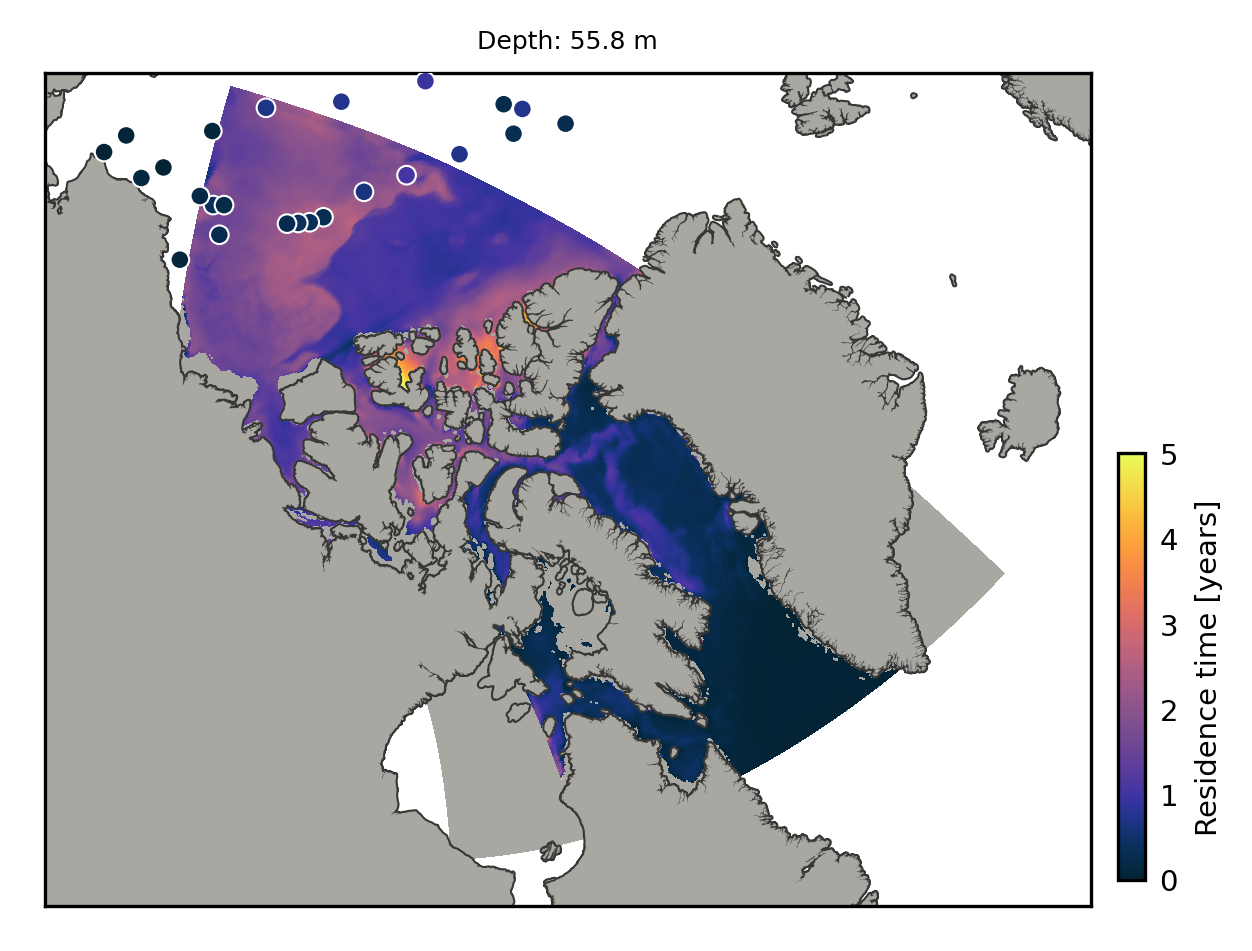

In [125]:
plot_layer(depth_weighted_restime5, 18, vmin=0, vmax=5)

#### Vertical variation in residence time

In [19]:
# Average basin profiles for different regions 
# --- Canada Basin ---
CB_mask  = np.zeros(bathy_masked.shape)
CB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CB_mask[depth][mesh_lon > -80]   = 0
    CB_mask[depth][hdept < 2000]     = 0

CB_mask[mesh_bathy < 0.1] = 0

# --- CAA ---
CAA_mask = np.zeros(bathy_masked.shape)
CAA_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    CAA_mask[depth][hdept > 500]     = 0
    CAA_mask[depth][mesh_lon < -130] = 0
    CAA_mask[depth][mesh_lon > -40]  = 0
    CAA_mask[depth][mesh_lat < 65]   = 0
    CAA_mask[depth][(mesh_lat < 75) & (mesh_lon >-75)] = 0
    
CAA_mask[mesh_bathy < 0.1] = 0

# --- Baffin Bay ---
BB_mask  = np.zeros(bathy_masked.shape)
BB_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    BB_mask[depth][mesh_lon < -75]   = 0
    BB_mask[depth][hdept < 1000]     = 0
    BB_mask[depth][mesh_lat <= 65]   = 0
    BB_mask[depth][mesh_lat > 80]    = 0

BB_mask[mesh_bathy < 0.1] = 0
    
# --- Labrador Sea ---
LS_mask  = np.zeros(bathy_masked.shape)
LS_mask[:,imin+10:imax-10,jmin+10:jmax-20] = 1 # excluding the regions of boundary conditions
for depth in range(0,50):
    LS_mask[depth][mesh_lon < -75]   = 0
    LS_mask[depth][mesh_lat > 65]    = 0
    LS_mask[depth][hdept < 2000]     = 0
    
LS_mask[mesh_bathy < 0.1] = 0

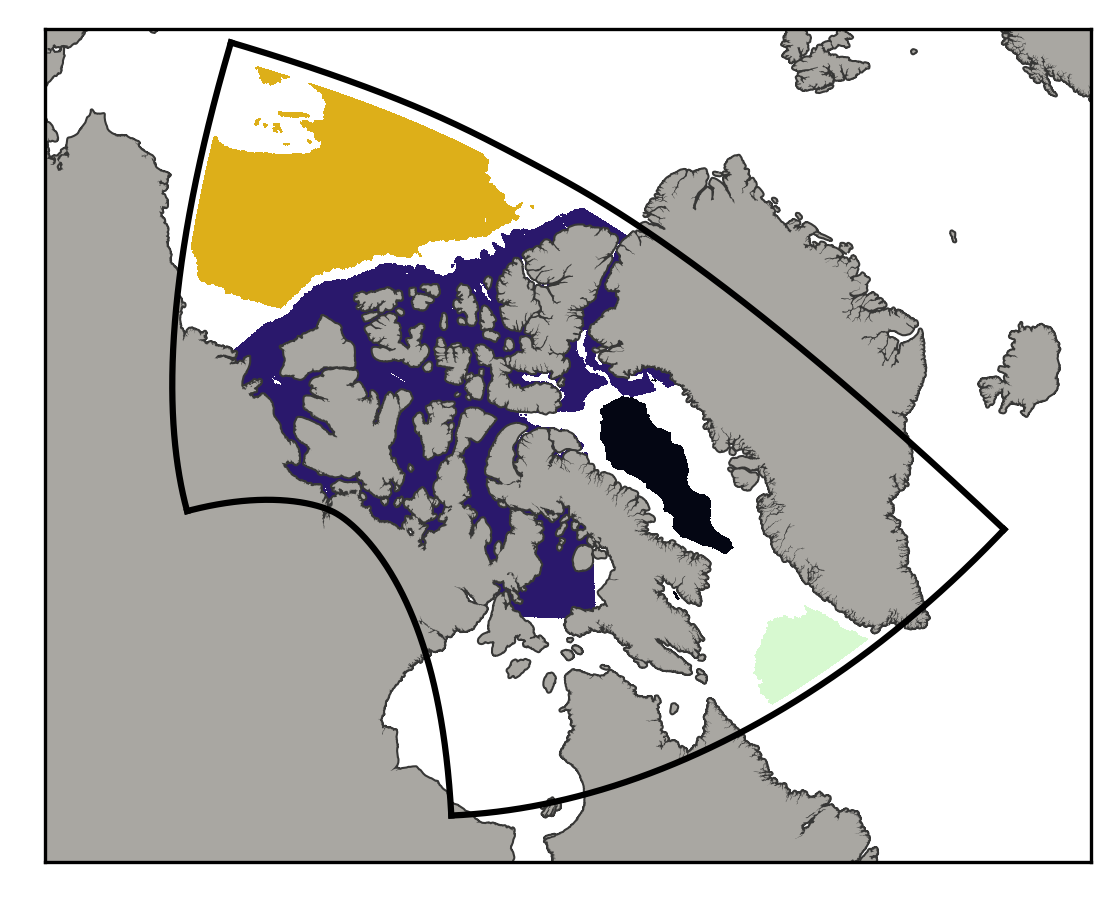

In [20]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

layer=0
x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 

proj1.plot(x[:,0] ,y[:,0] ,'-k')
proj1.plot(x[:,-1],y[:,-1],'-k')
proj1.plot(x[0,:] ,y[0,:] ,'-k')
proj1.plot(x[-1,:],y[-1,:],'-k')

CB_mask_plot  = np.ma.masked_where(CB_mask < 1 , CB_mask)
CAA_mask_plot = np.ma.masked_where(CAA_mask < 1, CAA_mask)
BB_mask_plot  = np.ma.masked_where(BB_mask < 1 , BB_mask)
LS_mask_plot  = np.ma.masked_where(LS_mask < 1 , LS_mask)
proj1.pcolormesh(x, y, CB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.oxy_r) 
proj1.pcolormesh(x, y, CAA_mask_plot[layer,imin:imax,jmin:jmax], cmap=cmocean.cm.haline)
proj1.pcolormesh(x, y, BB_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.ice) 
proj1.pcolormesh(x, y, LS_mask_plot[layer,imin:imax,jmin:jmax] , cmap=cmocean.cm.algae) 

In [21]:
def calc_regional_restime_profile(residence_time):
    
    # Separate based on region:
    CB_residence_time  = np.ma.masked_where(CB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    CAA_residence_time = np.ma.masked_where(CAA_mask[:,imin:imax,jmin:jmax]!=1, residence_time)
    BB_residence_time  = np.ma.masked_where(BB_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)
    LS_residence_time  = np.ma.masked_where(LS_mask[:,imin:imax,jmin:jmax]!=1 , residence_time)

    # Calculate mean over each of the regions:
    CB_mean_restime    = np.ma.mean(CB_residence_time , axis=(1,2))
    CAA_mean_restime   = np.ma.mean(CAA_residence_time, axis=(1,2))
    BB_mean_restime    = np.ma.mean(BB_residence_time , axis=(1,2))
    LS_mean_restime    = np.ma.mean(LS_residence_time , axis=(1,2))

    return CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime

In [50]:
def create_legend(axis, colors, markers):

    axis.set_xlim(-1,-0.5)
    axis.set_ylim(-1,-0.5)
    
    axis.plot([0,0], [0,0],'.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Observations:}$', markersize=7, color='w')      
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Kadko et al., 2018; Arctic', markersize=3, color=g, marker=markers[0])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Bacon et al., 1976; Atlantic', markersize=5, color=g, marker=markers[1])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Henderson and Maier-Reimer, 2002; Atlantic', markersize=5, color=g, marker=markers[2])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Moore and Smith, 1986; Arctic', markersize=5, color=g, marker=markers[3])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Craig et al., 1973; Pacific', markersize=5, color=g, marker=markers[4])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Nozaki et al, 1976; Pacific', markersize=7, color=g, marker=markers[5])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Schaul and Patterson, 1981; N. Pacific', markersize=7, color=g, marker=markers[6])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Schaul and Patterson, 1983; Sargasso', markersize=5, color=g, marker=markers[7])
    axis.plot([0,0], [0,0],'.', markeredgecolor='k', markeredgewidth=0.6, \
                     label='Chen et al., 2012; Chukchi Sea', markersize=5, color=g, marker=markers[8]) 
    
    
    axis.plot([0,0], [0,0],'.', markeredgecolor='w', markeredgewidth=0.0, \
                     label='   ', markersize=7, color='w')
    axis.plot([0,0], [0,0],'.', markeredgecolor='w', markeredgewidth=0.0, \
                     label=r'$\bf{Scavenging\ Rate:}$', markersize=7, color='w')  
    
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.2 \cdot 10^{-5}\ s^{-1}$', color=colors[0])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.5 \cdot 10^{-5}\ s^{-1}$', color=colors[1])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 0.8 \cdot 10^{-5}\ s^{-1}$', color=colors[2])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.0 \cdot 10^{-5}\ s^{-1}$', color=colors[3])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.2 \cdot 10^{-5}\ s^{-1}$', color=colors[4])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.4 \cdot 10^{-5}\ s^{-1}$', color=colors[5])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.6 \cdot 10^{-5}\ s^{-1}$', color=colors[6])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 1.8 \cdot 10^{-5}\ s^{-1}$', color=colors[7])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 3.0 \cdot 10^{-5}\ s^{-1}$', color=colors[8])
    axis.plot([0,0], [0,0], label=r'k$_{scav} = 5.0 \cdot 10^{-5}\ s^{-1}$', color=colors[9])

    return

In [53]:
def plot_profiles(ax, residence_time, markers, color='k'):
    
    CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime = calc_regional_restime_profile(residence_time)
    
    restimes = [CB_mean_restime, CAA_mean_restime, BB_mean_restime, LS_mean_restime]
    for n, axis in enumerate(ax.ravel()):
        axis.set_xlabel('Residence time [years]', fontsize=6)
        axis.tick_params(axis='both', labelsize=6)
        axis.invert_yaxis()
        axis.xaxis.tick_top()
        axis.xaxis.set_label_position('top') 

        # Model:
        axis.plot(restimes[n],  mesh_depth, '-', c=color) # CB
        
        # Observations:
        axis.plot(kadko_res, kadko_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=3, color=g, marker=markers[0])
        axis.plot(Bacon_restime, Bacon_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[1])
        axis.plot(HMR_restime, HMR_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[2])
        axis.plot(MS_restime, MS_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6,  markersize=5, color=g, marker=markers[3])
        axis.plot(craig_restime,  sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[4])
        axis.plot(nozaki_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=7, color=g, marker=markers[5])
        axis.plot(schaul1_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=7, color=g, marker=markers[6])
        axis.plot(schaul_restime, sid_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[7])
        axis.plot(chen_res, chen_ave_depth,'.', markeredgecolor='k', markeredgewidth=0.6, markersize=5, color=g, marker=markers[8]) 
        
#         axis.errorbar(HMR_restime, HMR_ave_depth, xerr=HMR_restime_err, yerr=0, color=g)
            
    return

In [45]:
folder_base = '/data/brogalla/run_storage/Pb-tuning-202210/'
residence_time_scav1 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav1/', 2002)
residence_time_scav2 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav2/', 2002)
residence_time_scav3 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav3/', 2002)
residence_time_scav4 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav4/', 2002)
residence_time_scav5 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav5/', 2002)
residence_time_scav6 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav6/', 2002)
residence_time_scav7 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav7/', 2002)
residence_time_scav8 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav8/', 2002)
residence_time_scav9 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav9/', 2002)
residence_time_scav10 = calc_annual_residence_time(f'{folder_base}Pb-tuning-202210-kscav10/', 2002)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


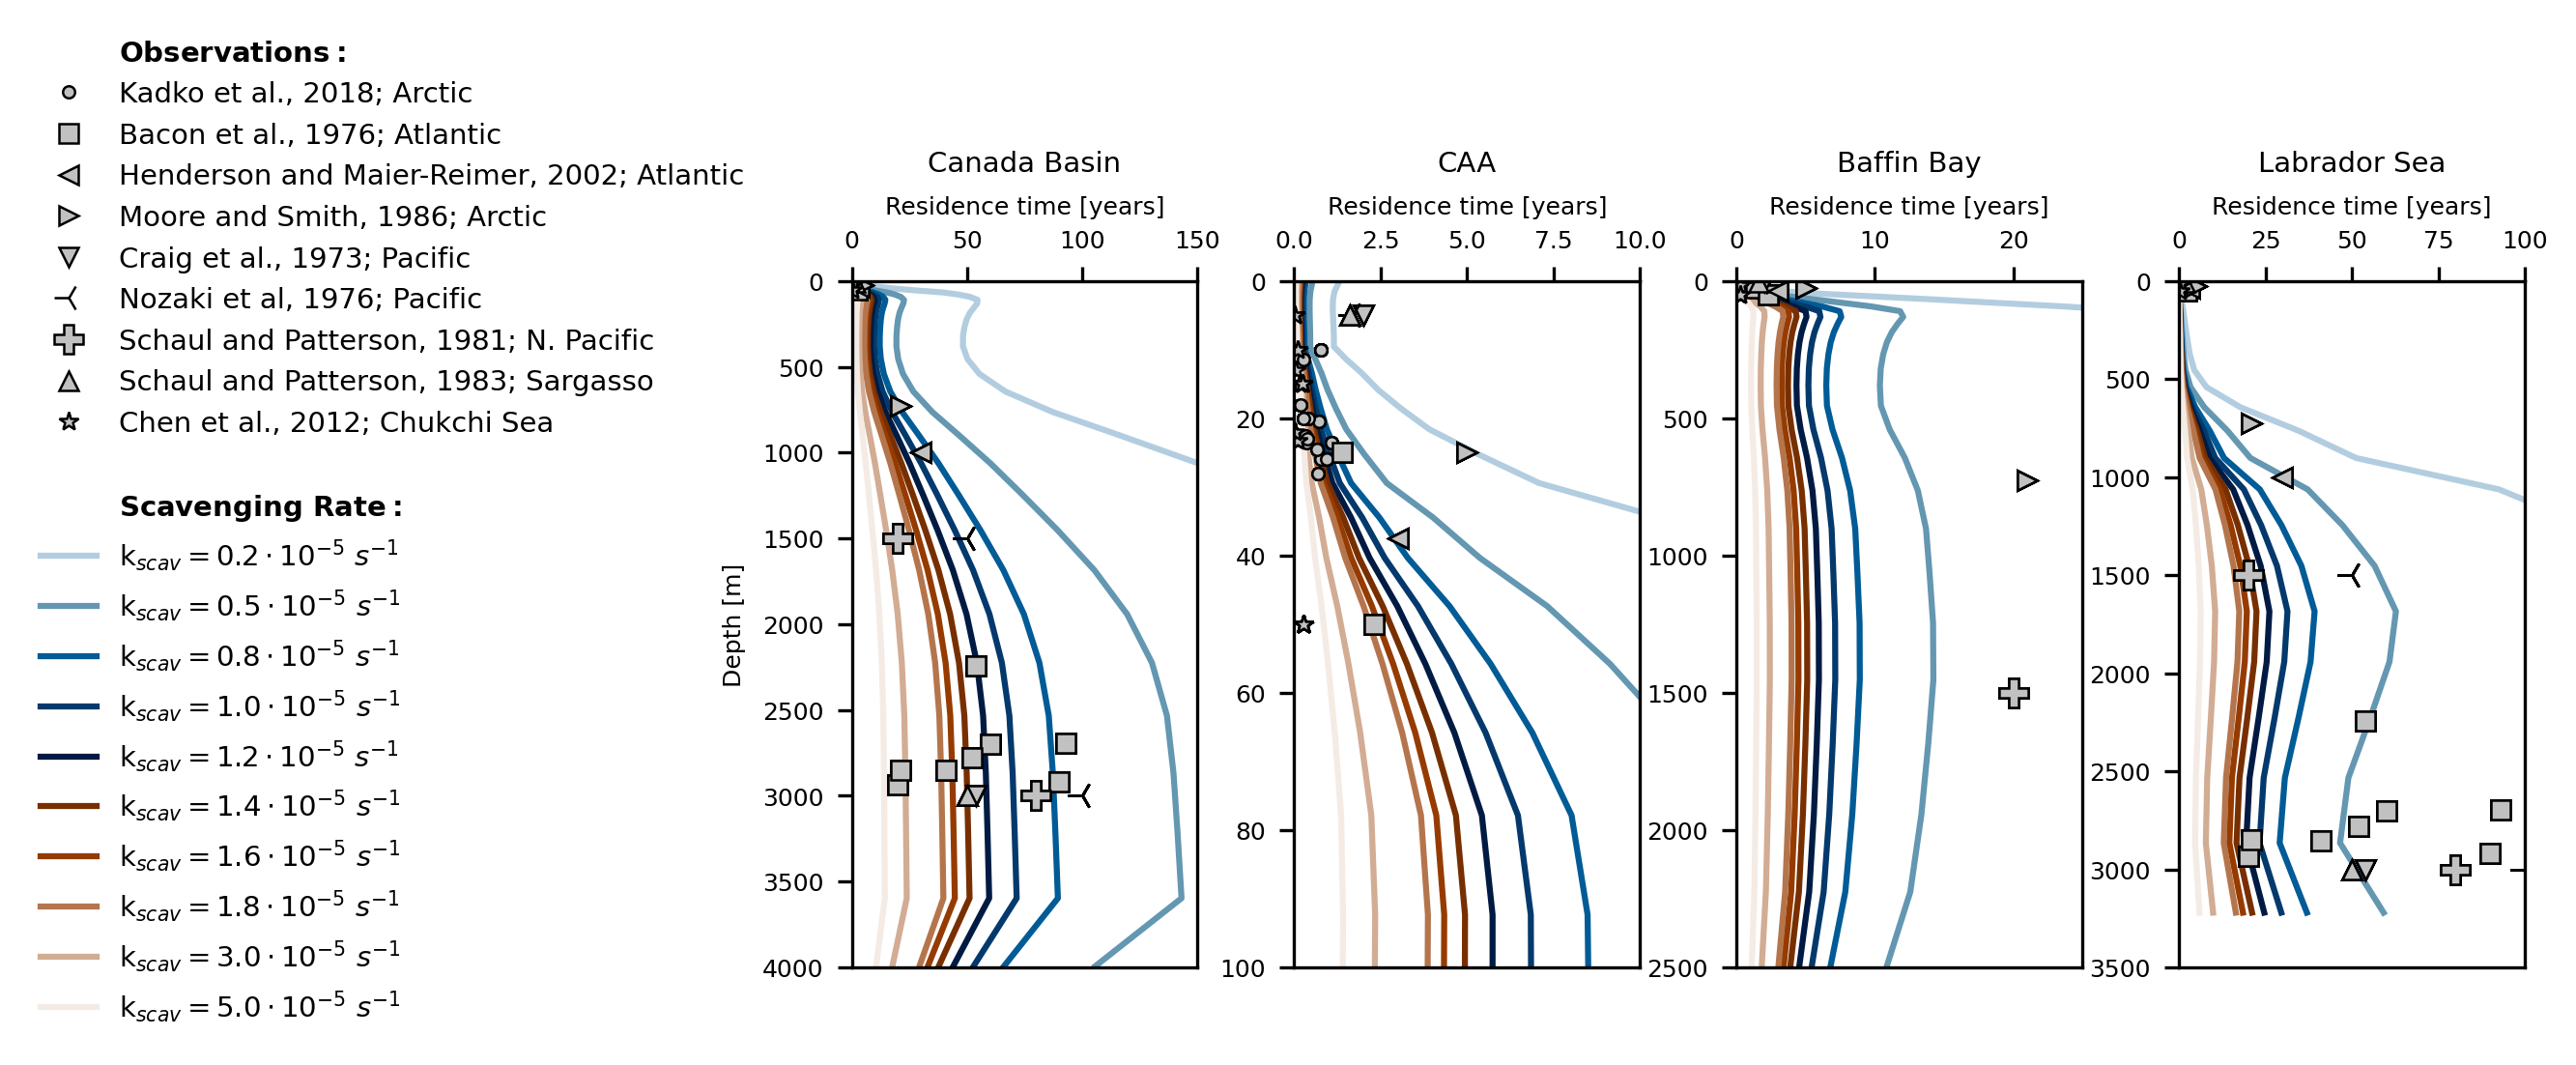

In [55]:
fig, ax = plt.subplots(1, 5, figsize=(9,3.5), dpi=300)

ax[0].axis('off')
ax[1].set_ylabel('Depth [m]', fontsize=6)
ax[1].set_title('Canada Basin', fontsize=7)
ax[2].set_title('CAA', fontsize=7)
ax[3].set_title('Baffin Bay', fontsize=7)
ax[4].set_title('Labrador Sea', fontsize=7)

markers  = ["o","s","<",">","v","3","P","^","*"]
colors   = ['#b3cde0','#6497b1','#005b96','#03396c','#001b43','#782f00', '#963b00','#b5754c','#d2ac93','#f4ebe5']

create_legend(ax[0], colors, markers)
plot_profiles(ax[1:5], residence_time_scav1, markers, color=colors[0])
plot_profiles(ax[1:5], residence_time_scav2, markers, color=colors[1])
plot_profiles(ax[1:5], residence_time_scav3, markers, color=colors[2])
plot_profiles(ax[1:5], residence_time_scav4, markers, color=colors[3])
plot_profiles(ax[1:5], residence_time_scav5, markers, color=colors[4])
plot_profiles(ax[1:5], residence_time_scav6, markers, color=colors[5])
plot_profiles(ax[1:5], residence_time_scav7, markers, color=colors[6])
plot_profiles(ax[1:5], residence_time_scav8, markers, color=colors[7])
plot_profiles(ax[1:5], residence_time_scav9, markers, color=colors[8])
plot_profiles(ax[1:5], residence_time_scav10, markers, color=colors[9])

ax[0].legend(loc=(-1.1, -0.1), fontsize=7, frameon=False)

# ax[1].set_ylim(100,0);  ax[1].set_xlim(0,1);
# ax[2].set_ylim(100,0);  ax[2].set_xlim(0,1);
ax[1].set_ylim(4000,0);  ax[1].set_xlim(0,150);
ax[2].set_ylim(100,0);  ax[2].set_xlim(0,10);
ax[3].set_ylim(2500,0); ax[3].set_xlim(0,25);
ax[4].set_ylim(3500,0);  ax[4].set_xlim(0,100);

plt.tight_layout(w_pad=-0.8)

Profiles show strong variation between regions when you plot them on the same axis scales, with strongest removal in the Labrador Sea, weakest in the Canada Basin, then CAA, Baffin Bay. The differences between CB, CAA, and BB are most obvious below 100 m, while LS is apparent everywhere.

For old observation sources where residence time is given for "surface", "intermediate", and "deep", I assign depths of 5 m, 1500 m, and 3000 m respectively.

Observed residence times are generally based on a range, where I mark the lower end of the range. For Moore and Smith, 1986 for example, residence time is 5 years for depth 2-200 m. I mark this at 200 m. This suggests that probably the residence time at 200 m itself should be somewhat higher than the observed residence time. Based on that information, maybe something like $1.2\cdot 10^{-5}\ s^{-1}$ is better than $1.8\cdot 10^{-5}\ s^{-1}$ which would otherwise look like a better fit.